In [5]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/72.0 MB ? eta -:--:--
    --------------------------------------- 1.3/72.0 MB 4.2 MB/s eta 0:00:17
   - -------------------------------------- 2.4/72.0 MB 4.5 MB/s eta 0:00:16
   - -------------------------------------- 3.4/72.0 MB 4.6 MB/s eta 0:00:15
   -- ------------------------------------- 3.7/72.0 MB 4.2 MB/s eta 0:00:17
   -- ------------------------------------- 4.7/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 5.5/72.0 MB 4.1 MB/s eta 0:00:17
   --- ------------------------------------ 6.6/72.0 MB 4.1 MB/s eta 0:00:16
   --- ------------------------------------ 7.1/72.0 MB 4.0 MB/s eta 0:00:17
   ---- ----------------------------------- 8.1/72.0 MB 4.2 MB/s eta 0:00:16
   ---- ----------------------------------- 8.9/72.0 MB 4.1 MB/s eta 0:00:16
   ----- ---------------------------------- 9.4/72.0 MB 3.9 MB/s eta 0:00:16
   ----- ----

# Phân lớp _ XG Boost 
Huấn luyện riêng lẻ từng cổ phiếu 

Bắt đầu huấn luyện riêng lẻ cho 5 mã cổ phiếu...

--- Đang xử lý mã: FPT ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST (FPT) ---
Accuracy của XGBoost: 0.5058

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)       0.50      0.93      0.65       215
    TĂNG (1)       0.56      0.09      0.15       218

    accuracy                           0.51       433
   macro avg       0.53      0.51      0.40       433
weighted avg       0.53      0.51      0.40       433


--- Đang xử lý mã: HPG ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST (HPG) ---
Accuracy của XGBoost: 0.5404

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)       0.55      0.83      0.66       236
    TĂNG (1)       0.49      0.19      0.28       197

    accuracy                           0.54       433
   macro avg       0.52      0.51      0.47       433
weighted avg       0.52      0.54      0.49       433


--- Đang xử lý mã: KDH ---



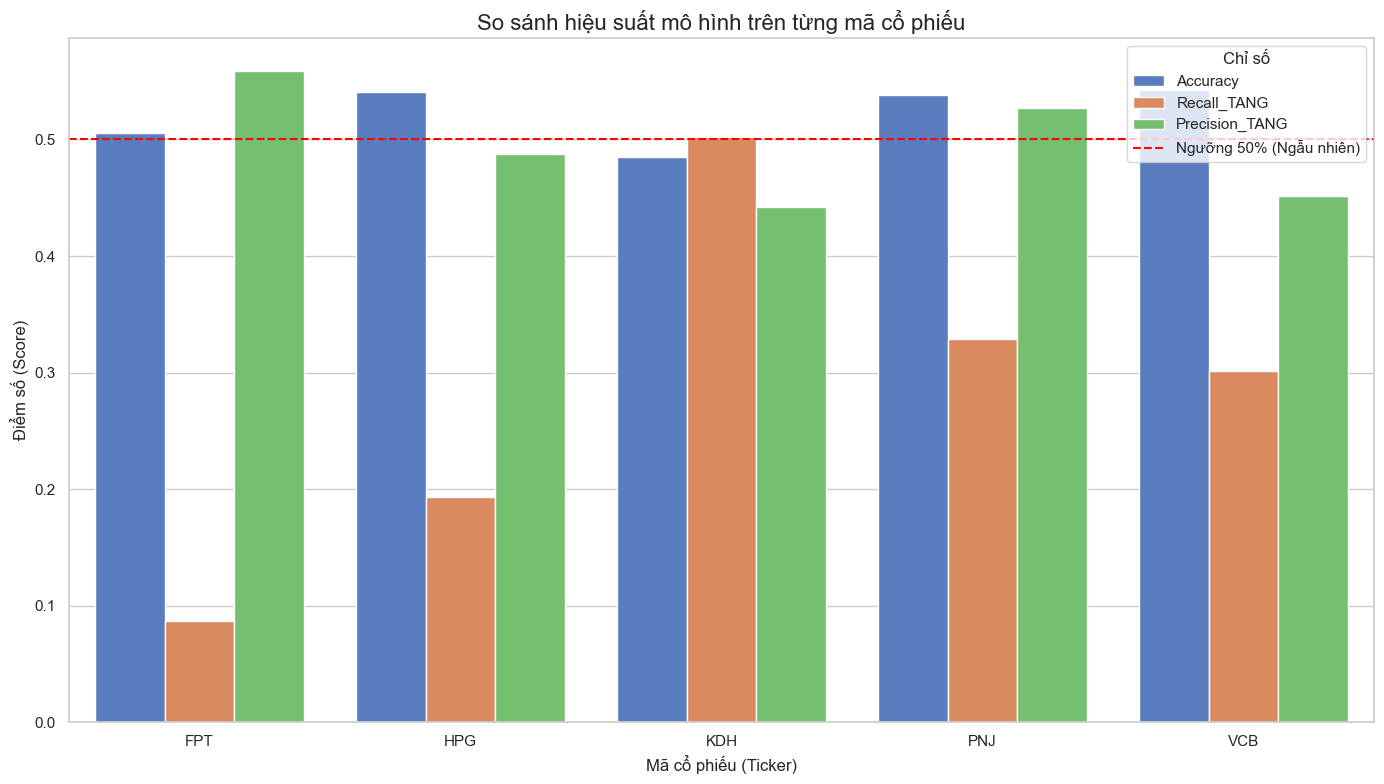


--- Đang vẽ biểu đồ Precision & Recall cho từng lớp ---
ĐÃ LƯU: precision_recall_difference.png


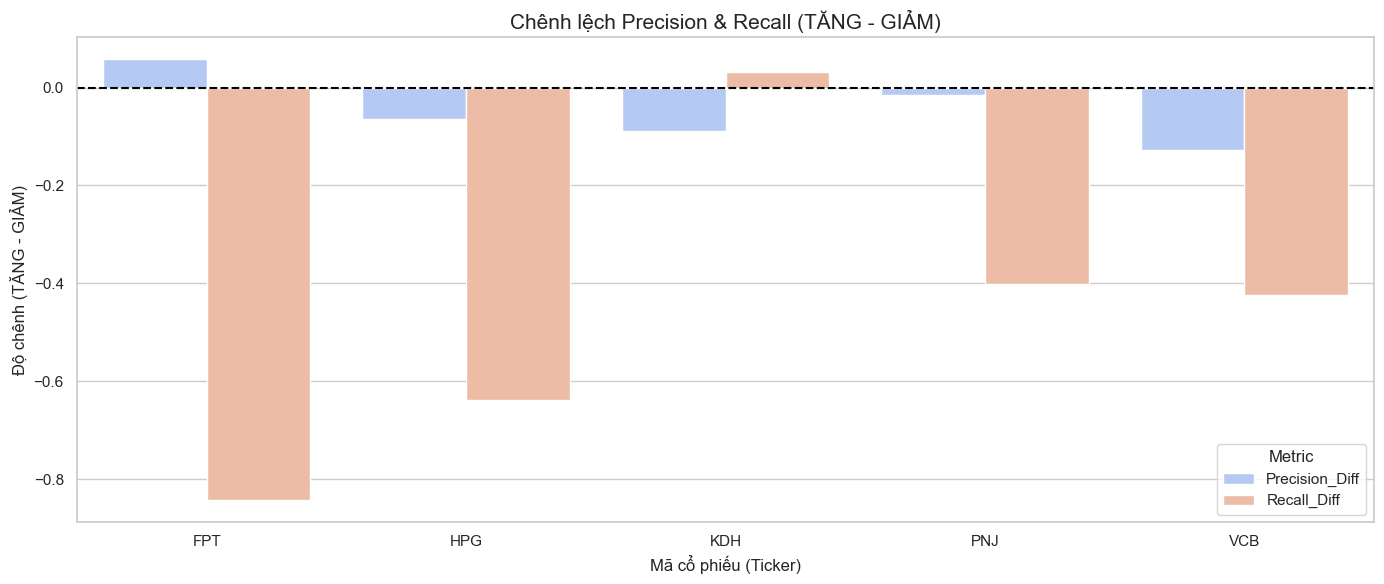


--- Đang vẽ Heatmap tổng quan Precision/Recall ---
ĐÃ LƯU: precision_recall_heatmap.png


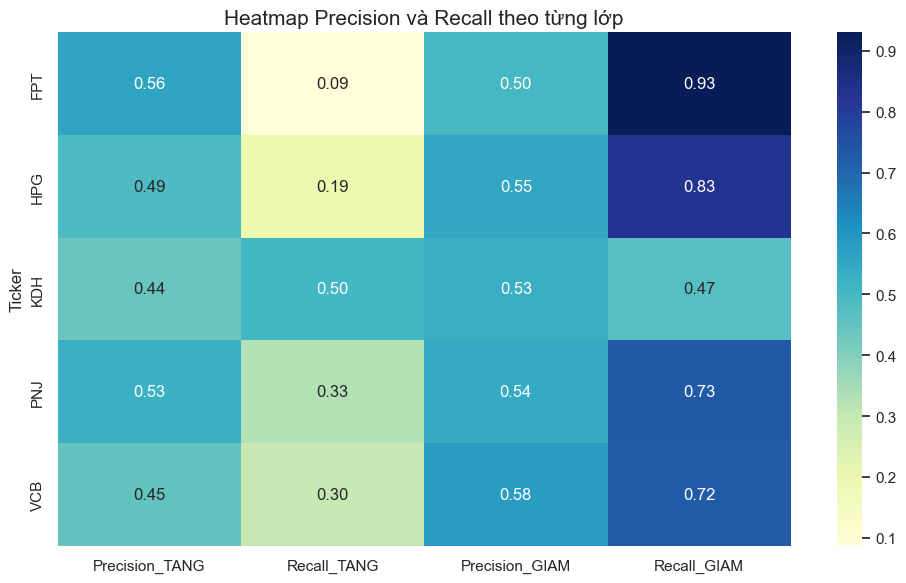


 TẤT CẢ 15 FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'huanluyenriengle'

--- TỔNG THỜI GIAN CHẠY: 0.22 phút ---


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import time
import os
import shutil 

# Cài đặt chung
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# --- HÀM 1: CÔNG CỤ LẤY METRIC AN TOÀN ---
def safe_get(report_dict, label, metric):
    """ Lấy metric an toàn; nếu lớp không xuất hiện (do 0 mẫu) thì trả 0.0 """
    return float(report_dict.get(label, {}).get(metric, 0.0))

# --- HÀM 2: LÕI HUẤN LUYỆN (GIỮ NGUYÊN) ---
def train_model_for_ticker(ticker_data, features, date_split='2024-01-01'):
    """
    Hàm này huấn luyện một mô hình XGBoost (đã Tinh chỉnh) cho MỘT ticker.
    """
    
    # 2. CHIA DỮ LIỆU TRAIN/TEST
    train_data = ticker_data[ticker_data['Date'] < date_split]
    test_data = ticker_data[ticker_data['Date'] >= date_split]
    
    if train_data.empty or test_data.empty:
        print(f"  -> Bỏ qua: Không đủ dữ liệu Train/Test quanh mốc {date_split}.")
        return None

    X_train = train_data[features]
    y_train = train_data['Target']
    X_test = test_data[features]
    y_test = test_data['Target']

    # 3. TINH CHỈNH THAM SỐ
    
    # 3.1. Tính 'scale_pos_weight'
    count_neg = (y_train == 0).sum()
    count_pos = (y_train == 1).sum()
    scale_pos_weight = 1 if count_pos == 0 else (count_neg / count_pos)

    # 3.2. Định nghĩa "Menu" tham số
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }

    # 3.3. Mô hình XGBoost cơ sở
    model_base = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )

    # 3.4. Cài đặt TimeSeriesSplit (dùng n_splits=3 để nhanh hơn)
    tscv = TimeSeriesSplit(n_splits=3)

    # 3.5. Cài đặt RandomizedSearchCV (n_iter=15 để nhanh hơn)
    random_search = RandomizedSearchCV(
        estimator=model_base,
        param_distributions=param_dist,
        n_iter=15, 
        scoring='accuracy',
        cv=tscv,
        n_jobs=-1,
        random_state=42,
        verbose=0 # Tắt bớt log
    )

    # 3.6. Chạy quá trình "dò"
    random_search.fit(X_train, y_train)

    # 4. ĐÁNH GIÁ MÔ HÌNH
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # Lấy cả 2 dạng báo cáo
    report_dict = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], output_dict=True)
    text_report = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=2)

    return {
        'accuracy': accuracy,
        'best_params': random_search.best_params_,
        'report': report_dict,
        'text_report': text_report, 
        'y_test': y_test,         
        'y_pred': y_pred,         
        'test_samples': len(y_test)
    }

# --- HÀM 3: CHẠY VÒNG LẶP HUẤN LUYỆN VÀ XUẤT FILE CHO TỪNG MÃ ---
def run_training_loop(df_ml, features):
    """
    Chạy vòng lặp huấn luyện qua từng Ticker.
    In kết quả, lưu file .txt và .png cho từng mã.
    """
    tickers = sorted(df_ml['Ticker'].unique())
    all_results = {}
    results_list_for_csv = []
    
    print(f"Bắt đầu huấn luyện riêng lẻ cho {len(tickers)} mã cổ phiếu...")

    for ticker in tickers:
        print(f"\n--- Đang xử lý mã: {ticker} ---")
        ticker_data = df_ml[df_ml['Ticker'] == ticker].copy()
        result = train_model_for_ticker(ticker_data, features)

        if not result:
            print("  -> Bỏ qua ticker này (không đủ train/test).")
            continue

        all_results[ticker] = result

        # In báo cáo chi tiết cho từng mã
        print(f"\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST ({ticker}) ---")
        print(f"Accuracy của XGBoost: {result['accuracy']:.4f}\n")
        print("Báo cáo Phân loại chi tiết:")
        print(result['text_report']) 

        # Lưu báo cáo text cho từng mã
        with open(f"classification_report_{ticker}.txt", "w", encoding="utf-8") as f:
            f.write(result['text_report'])

        # Vẽ và lưu Confusion Matrix cho từng mã
        cm = confusion_matrix(result['y_test'], result['y_pred'], labels=[0, 1])
        plt.figure(figsize=(4.2, 3.6))
        sns.heatmap(
            cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Dự đoán GIẢM (0)', 'Dự đoán TĂNG (1)'],
            yticklabels=['Thực tế GIẢM (0)', 'Thực tế TĂNG (1)']
        )
        plt.title(f'Confusion Matrix – {ticker}')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{ticker}.png', dpi=150)
        plt.close()

        # Thêm vào danh sách để tổng hợp
        rpt = result['report']
        results_list_for_csv.append({
            'Ticker': ticker,
            'Accuracy': result['accuracy'],
            'Precision_TANG': safe_get(rpt, 'TĂNG (1)', 'precision'),
            'Recall_TANG':    safe_get(rpt, 'TĂNG (1)', 'recall'),
            'Precision_GIAM': safe_get(rpt, 'GIẢM (0)', 'precision'),
            'Recall_GIAM':    safe_get(rpt, 'GIẢM (0)', 'recall'),
            'Test_Samples': result['test_samples'],
            'Best_Params': str(result['best_params'])
        })
        
    return all_results, results_list_for_csv

# --- HÀM 4: XUẤT BÁO CÁO TỔNG HỢP VÀ VẼ BIỂU ĐỒ ---
def generate_summary_and_plots(all_results, results_list_for_csv, pooled_accuracy):
    """
    In tóm tắt, lưu file CSV tổng hợp, và vẽ 3 biểu đồ so sánh.
    """
    print("\n--- BÁO CÁO KẾT QUẢ TỪNG MÔ HÌNH ---")
    total_samples = 0
    weighted_accuracy_sum = 0
    all_reports_text = ""

    for ticker in sorted(all_results.keys()):
        res = all_results[ticker]; rpt = res['report']
        prec_up = safe_get(rpt, 'TĂNG (1)', 'precision')
        rec_up  = safe_get(rpt, 'TĂNG (1)', 'recall')
        prec_dn = safe_get(rpt, 'GIẢM (0)', 'precision')
        rec_dn  = safe_get(rpt, 'GIẢM (0)', 'recall')

        print(f"\n======== {ticker} ========")
        print(f"  Accuracy:          {res['accuracy']:.4f}")
        print(f"  --- Lớp TĂNG (1) --- Precision: {prec_up:.4f} | Recall: {rec_up:.4f}")
        print(f"  --- Lớp GIẢM (0) --- Precision: {prec_dn:.4f} | Recall: {rec_dn:.4f}")
        
        # Thêm vào file text tổng
        all_reports_text += f"--- {ticker} ---\nAccuracy: {res['accuracy']:.4f}\n{res['text_report']}\n\n"
        
        total_samples += res['test_samples']
        weighted_accuracy_sum += res['accuracy'] * res['test_samples']

    # Lưu file text tổng hợp
    with open("all_classification_reports.txt", "w", encoding="utf-8") as f:
        f.write(all_reports_text)
    print("\nĐÃ LƯU: all_classification_reports.txt")

    # Tính và in kết quả trung bình
    if total_samples > 0:
        final_weighted_accuracy = weighted_accuracy_sum / total_samples
        print("\n======================================")
        print(f"ĐỘ CHÍNH XÁC TRUNG BÌNH (Có trọng số): {final_weighted_accuracy:.4f}")
        print(f"So với Mô hình Gộp (Pooled Model): {pooled_accuracy:.4f}")
    
    # --- VẼ BIỂU ĐỒ VÀ LƯU CSV ---
    if not results_list_for_csv:
        return # Không có gì để vẽ

    # Tạo DataFrame để vẽ
    df_plot = pd.DataFrame(results_list_for_csv)
    cols_order = ['Ticker', 'Accuracy', 'Precision_TANG', 'Recall_TANG', 
                  'Precision_GIAM', 'Recall_GIAM', 'Test_Samples', 'Best_Params']
    df_plot = df_plot[cols_order]

    # Lưu CSV
    df_plot.to_csv('all_ticker_model_results.csv', index=False, encoding='utf-8')
    print("ĐÃ LƯU: all_ticker_model_results.csv")
    
    # Biểu đồ 1: So sánh Accuracy, Recall_TANG, Precision_TANG
    print("\n--- Đang vẽ biểu đồ so sánh hiệu suất mô hình ---")
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=df_plot.melt(id_vars=['Ticker'], value_vars=['Accuracy', 'Recall_TANG', 'Precision_TANG'], var_name='Metric', value_name='Score'),
        x='Ticker', y='Score', hue='Metric', palette='muted'
    )
    plt.title('So sánh hiệu suất mô hình trên từng mã cổ phiếu', fontsize=16)
    plt.ylabel('Điểm số (Score)', fontsize=12)
    plt.xlabel('Mã cổ phiếu (Ticker)', fontsize=12)
    plt.axhline(y=0.5, color='red', linestyle='--', label='Ngưỡng 50% (Ngẫu nhiên)')
    plt.legend(title='Chỉ số', loc='upper right')
    plt.tight_layout()
    plt.savefig('model_comparison_barplot.png')
    print("ĐÃ LƯU: model_comparison_barplot.png")
    plt.show()

    # Biểu đồ 2: So sánh chênh lệch Precision & Recall
    print("\n--- Đang vẽ biểu đồ Precision & Recall cho từng lớp ---")
    df_diff = df_plot[['Ticker', 'Precision_TANG', 'Recall_TANG', 'Precision_GIAM', 'Recall_GIAM']].copy()
    df_diff['Precision_Diff'] = df_diff['Precision_TANG'] - df_diff['Precision_GIAM']
    df_diff['Recall_Diff'] = df_diff['Recall_TANG'] - df_diff['Recall_GIAM']
    
    plt.figure(figsize=(14, 6))
    sns.barplot(
        data=df_diff.melt(id_vars='Ticker', value_vars=['Precision_Diff', 'Recall_Diff'], var_name='Metric', value_name='Delta'),
        x='Ticker', y='Delta', hue='Metric', palette='coolwarm'
    )
    plt.axhline(0, color='black', linestyle='--')
    plt.title('Chênh lệch Precision & Recall (TĂNG - GIẢM)', fontsize=15)
    plt.ylabel('Độ chênh (TĂNG - GIẢM)', fontsize=12)
    plt.xlabel('Mã cổ phiếu (Ticker)', fontsize=12)
    plt.tight_layout()
    plt.savefig('precision_recall_difference.png')
    print("ĐÃ LƯU: precision_recall_difference.png")
    plt.show()

    # Biểu đồ 3: Heatmap
    print("\n--- Đang vẽ Heatmap tổng quan Precision/Recall ---")
    plt.figure(figsize=(10, 6))
    heatmap_data = df_plot.set_index('Ticker')[['Precision_TANG', 'Recall_TANG', 'Precision_GIAM', 'Recall_GIAM']]
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
    plt.title('Heatmap Precision và Recall theo từng lớp', fontsize=15)
    plt.tight_layout()
    plt.savefig('precision_recall_heatmap.png')
    print("ĐÃ LƯU: precision_recall_heatmap.png")
    plt.show()

# --- HÀM 5: DỌN DẸP FILE ---
def organize_output_files(output_folder="huanluyenriengle"):
    """
    Gom tất cả file kết quả vào một thư mục.
    """
    os.makedirs(output_folder, exist_ok=True) 
    
    file_patterns = [
        "classification_report_", "confusion_matrix_", 
        "model_comparison_barplot.png", "precision_recall_difference.png",
        "precision_recall_heatmap.png", "all_ticker_model_results.csv",
        "all_classification_reports.txt"
    ]
    
    moved_files = []
    for fname in os.listdir("."):
        for pattern in file_patterns:
            if fname.startswith(pattern) or fname == pattern:
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                    moved_files.append(fname)
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")
                break # Đã tìm thấy, di chuyển và sang file tiếp theo

    print(f"\n TẤT CẢ {len(moved_files)} FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

# --- HÀM CHẠY CHÍNH ---
def main():
    """
    Hàm chính điều phối toàn bộ quy trình.
    """
    start_time = time.time()
    
    # 1. Đọc và chuẩn bị dữ liệu
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    df_ml = df.dropna()

    features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay',
        'SMA', 'Bollinger_Upper', 'Bollinger_Lower',
        'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    
    # 2. Chạy vòng lặp huấn luyện
    all_results, results_list_for_csv = run_training_loop(df_ml, features)
    
    # 3. Tổng hợp kết quả và vẽ biểu đồ
    if results_list_for_csv:
        generate_summary_and_plots(all_results, results_list_for_csv, pooled_accuracy=0.5339)
    else:
        print("\nKhông có kết quả nào được tạo ra.")
        
    # 4. Dọn dẹp file
    organize_output_files()

    end_time = time.time()
    print(f"\n--- TỔNG THỜI GIAN CHẠY: {((end_time - start_time) / 60):.2f} phút ---")

# --- ĐIỂM BẮT ĐẦU CHẠY ---
if __name__ == "__main__":
    try:
        main()
    except FileNotFoundError:
        print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
    except ImportError:
        print("\nLỗi: Thư viện XGBoost hoặc các thư viện khác chưa được cài đặt.")
    except Exception as e:
        print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

Phân lớp _ XG Boost - Huấn luyện cả 5 mã

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Mẫu huấn luyện: 9900 (trước 2024-01-01)
Mẫu kiểm thử: 2165 (từ 2024-01-01 trở đi)

Tính toán scale_pos_weight:
  Số mẫu GIẢM (0) trong tập Train: 5233
  Số mẫu TĂNG (1) trong tập Train: 4667
  => scale_pos_weight = 5233 / 4667 = 1.1213

--- Bắt đầu huấn luyện mô hình XGBoost (với scale_pos_weight) ---
--- Mô hình XGBoost (ĐÃ CÂN BẰNG) đã huấn luyện thành công! ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST ---
Accuracy của XGBoost: 0.5339

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5565    0.6414    0.5959      1160
    TĂNG (1)     0.4976    0.4100    0.4495      1005

    accuracy                         0.5339      2165
   macro avg     0.5270    0.5257    0.5227      2165
weighted avg     0.5291    0.5339    0.5280      2165


Đã lưu Báo cáo Phân loại tại 'pooled_model_report.txt'

--- Đang tạo các biểu đồ đánh giá ---


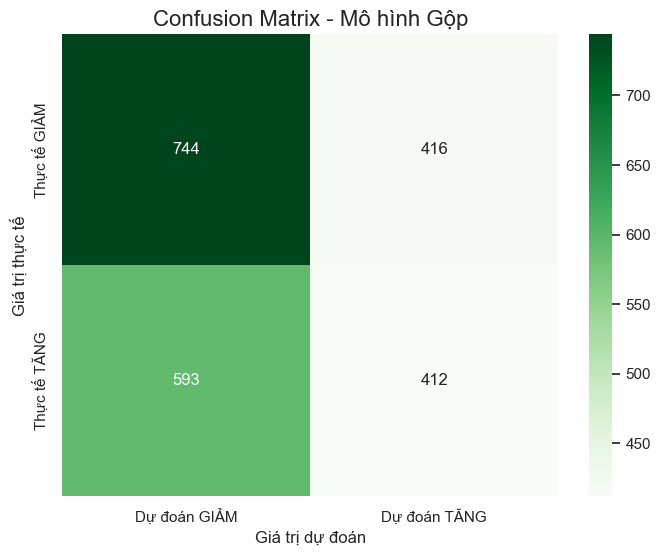

Đã lưu Confusion Matrix tại 'pooled_confusion_matrix.png'


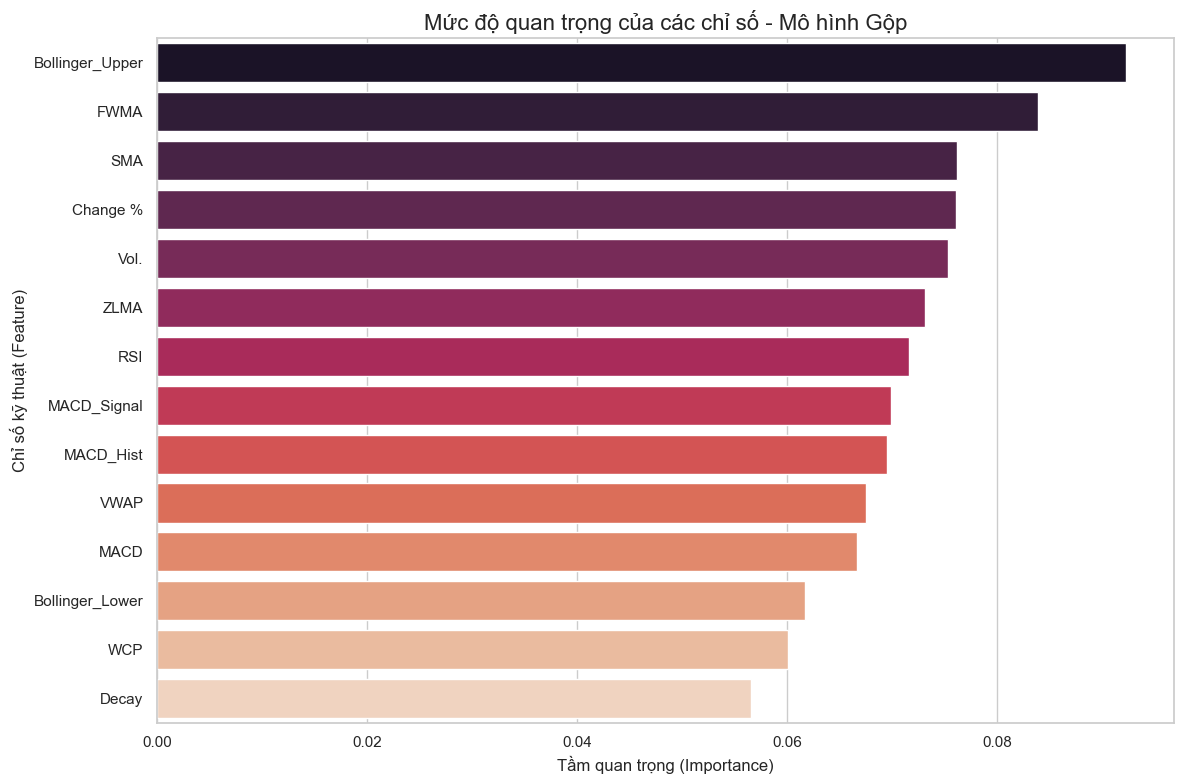

Đã lưu Feature Importance tại 'pooled_feature_importance.png'

--- Đang gom file vào thư mục 'huanluyen5ma' ---

 TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'huanluyen5ma'


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU CHO MACHINE LEARNING
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    
    # Loại bỏ NaN
    df_ml = df.dropna()

    features = ['Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
    'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']

    # Dùng cách chia theo thời gian
    print("--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng. Hãy kiểm tra lại mốc ngày '2024-01-01'.")
    else:
        X_train = train_data[features]
        y_train = train_data['Target']
        
        X_test = test_data[features]
        y_test = test_data['Target']

        print(f"Mẫu huấn luyện: {len(X_train)} (trước 2024-01-01)")
        print(f"Mẫu kiểm thử: {len(X_test)} (từ 2024-01-01 trở đi)")

        # 3. HUẤN LUYỆN MÔ HÌNH XGBOOST (Giữ nguyên)
        # TÍNH TOÁN scale_pos_weight TỪ DỮ LIỆU HUẤN LUYỆN
        count_neg = (y_train == 0).sum()
        count_pos = (y_train == 1).sum()
        
        if count_pos > 0:
            scale_pos_weight = count_neg / count_pos
            print(f"\nTính toán scale_pos_weight:")
            print(f"  Số mẫu GIẢM (0) trong tập Train: {count_neg}")
            print(f"  Số mẫu TĂNG (1) trong tập Train: {count_pos}")
            print(f"  => scale_pos_weight = {count_neg} / {count_pos} = {scale_pos_weight:.4f}")
        else:
            scale_pos_weight = 1
            print("Cảnh báo: Không tìm thấy mẫu TĂNG (1) trong tập huấn luyện.")

        print("\n--- Bắt đầu huấn luyện mô hình XGBoost (với scale_pos_weight) ---")
        
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42,
            scale_pos_weight=scale_pos_weight 
        )
        
        model.fit(X_train, y_train)
        print("--- Mô hình XGBoost (ĐÃ CÂN BẰNG) đã huấn luyện thành công! ---")

        # 4. ĐÁNH GIÁ MÔ HÌNH
        y_pred = model.predict(X_test)
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH XGBOOST ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của XGBoost: {accuracy:.4f}")
        
        # Tạo báo cáo dạng text (string)
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) # In ra màn hình

        # Đặt tên file
        report_filename = 'pooled_model_report.txt'
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH GỘP (POOLED MODEL) ---\n")
            f.write(f"Accuracy của XGBoost: {accuracy:.4f}\n\n")
            f.write("Báo cáo Phân loại chi tiết:\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")
        
        # 5. TRỰC QUAN HÓA KẾT QUẢ
        print("\n--- Đang tạo các biểu đồ đánh giá ---")
        
        cm_filename = 'pooled_confusion_matrix.png'
        fi_filename = 'pooled_feature_importance.png'
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - Mô hình Gộp', fontsize=16)
        plt.ylabel('Giá trị thực tế', fontsize=12)
        plt.xlabel('Giá trị dự đoán', fontsize=12)
        plt.savefig(cm_filename)

        plt.show() 
        plt.close()
        # ------------------------------------
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")
        
        # Feature Importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')
        plt.title('Mức độ quan trọng của các chỉ số - Mô hình Gộp', fontsize=16)
        plt.xlabel('Tầm quan trọng (Importance)', fontsize=12)
        plt.ylabel('Chỉ số kỹ thuật (Feature)', fontsize=12)
        plt.tight_layout()
        plt.savefig(fi_filename)
        plt.show() 
        plt.close()
  
        print(f"Đã lưu Feature Importance tại '{fi_filename}'")
        
        # Lưu folder
        output_folder = "huanluyen5ma" 
        os.makedirs(output_folder, exist_ok=True) 

        # Cập nhật danh sách file
        file_patterns = [
            report_filename, 
            cm_filename,
            fi_filename
        ]

        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in file_patterns:
            if os.path.exists(fname): # Kiểm tra file tồn tại
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")
        # --- HẾT THAY ĐỔI ---

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện XGBoost chưa được cài đặt.")
    print("Vui lòng chạy lệnh: pip install xgboost")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp _ Random Forest 

--- Đang thêm Đặc trưng Tương tác ---
Đã tạo: Price_vs_SMA, Price_vs_ZLMA, Bollinger_Width_Normalized

--- Đang thêm các Đặc trưng Trễ ---
Đã tạo cột: ZLMA_lag_1
Đã tạo cột: ZLMA_lag_2
Đã tạo cột: RSI_lag_1
Đã tạo cột: RSI_lag_2
Đã tạo cột: MACD_Hist_lag_1
Đã tạo cột: MACD_Hist_lag_2
Đã tạo cột: Change %_lag_1
Đã tạo cột: Change %_lag_2
Đã tạo cột: Vol._lag_1
Đã tạo cột: Price_vs_SMA_lag_1
Đã tạo cột: Bollinger_Width_Normalized_lag_1

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Tổng số features: 28
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Bắt đầu huấn luyện mô hình Random Forest ---
--- Mô hình Random Forest đã huấn luyện thành công! ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---
Accuracy của Random Forest: 0.5229

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5392    0.7534    0.6286      1160
    TĂNG (1)     0.4743    0.2567    0.3331      1005

    accuracy                         0.5229      2165
   macro

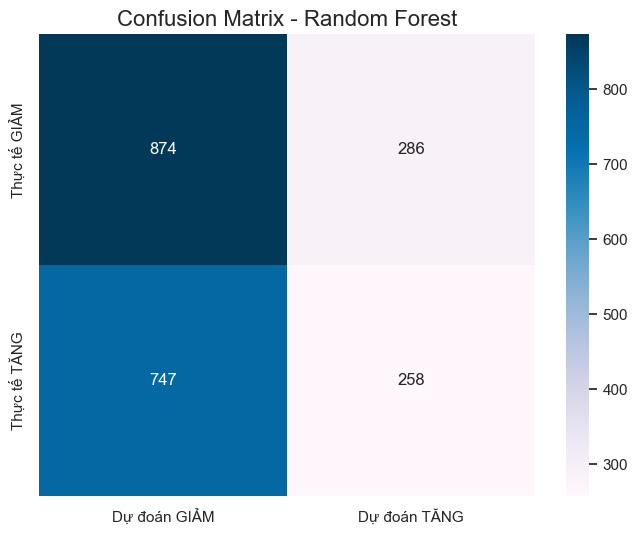

Đã lưu Confusion Matrix tại 'rf_confusion_matrix.png'


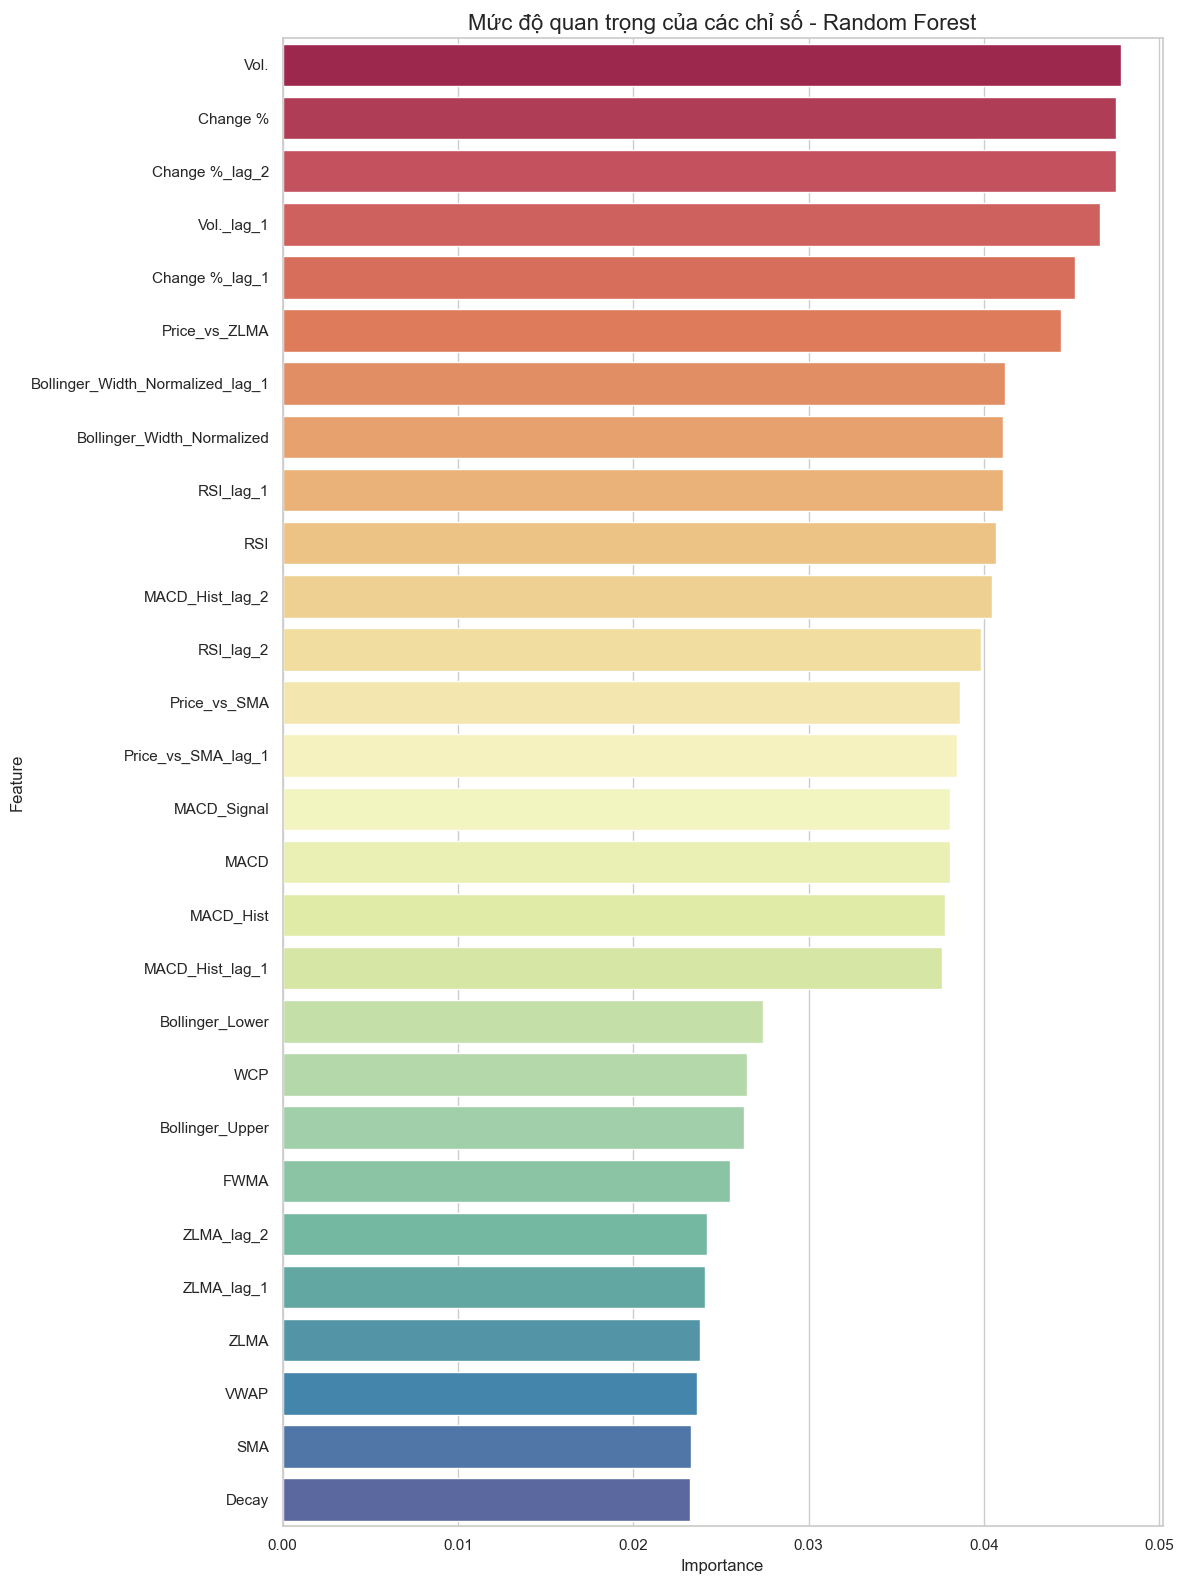

Đã lưu Feature Importance tại 'rf_feature_importance.png'

--- Đang gom file vào thư mục 'random_forest_model' ---

✅ TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'random_forest_model'


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# --- THƯ VIỆN MỚI ---
from sklearn.ensemble import RandomForestClassifier
# --------------------
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
    Hàm này thêm cả Đặc trưng Tương tác VÀ Đặc trưng Trễ.
    """
    # --- 1. Thêm Đặc trưng Tương tác (Interaction Features) ---
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']
    print("Đã tạo: Price_vs_SMA, Price_vs_ZLMA, Bollinger_Width_Normalized")

    # --- 2. Thêm Đặc trưng Trễ (Lag Features) ---
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    
    for feature, lags in features_to_lag.items():
        if feature not in df.columns:
            print(f"Cảnh báo: Không tìm thấy cột '{feature}' để tạo lag.")
            continue
            
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
            print(f"Đã tạo cột: {col_name}")
            
    return df

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    
    df_with_features = add_lag_and_interaction_features(df)
    
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = [
        'Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized'
    ]
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = base_features + interaction_features + lag_features

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng. Hãy kiểm tra lại mốc ngày '2024-01-01'.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Tổng số features: {len(all_features)}")
        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # 4. HUẤN LUYỆN MÔ HÌNH RANDOM FOREST
        print("\n--- Bắt đầu huấn luyện mô hình Random Forest ---")
        
        model = RandomForestClassifier(
            n_estimators=100,       # 100 cây (mặc định hợp lý)
            random_state=42,
            class_weight='balanced', # Tự động xử lý mất cân bằng
            n_jobs=-1               # Dùng tất cả CPU
        )
        
        model.fit(X_train, y_train)
        print("--- Mô hình Random Forest đã huấn luyện thành công! ---")

        # 5. ĐÁNH GIÁ MÔ HÌNH
        y_pred = model.predict(X_test)
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH RANDOM FOREST ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của Random Forest: {accuracy:.4f}")
        
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) 

        # 6. LƯU KẾT QUẢ
        output_folder = "random_forest_model"
        os.makedirs(output_folder, exist_ok=True) 
        
        report_filename = 'rf_report.txt'
        cm_filename = 'rf_confusion_matrix.png'
        fi_filename = 'rf_feature_importance.png'
        
        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ MÔ HÌNH RANDOM FOREST (28 Features) ---\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - Random Forest', fontsize=16)
        plt.savefig(cm_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")
        
        # Vẽ và lưu Feature Importance
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': all_features,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        plt.figure(figsize=(12, 16)) 
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='Spectral')
        plt.title('Mức độ quan trọng của các chỉ số - Random Forest', fontsize=16)
        plt.tight_layout()
        plt.savefig(fi_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Feature Importance tại '{fi_filename}'")
        
        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in [report_filename, cm_filename, fi_filename]:
            if os.path.exists(fname):
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n✅ TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân lớp - SVM _ SVC

--- Đang thêm Đặc trưng Tương tác ---

--- Đang thêm các Đặc trưng Trễ ---

--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---
Tổng số features: 28
Mẫu huấn luyện: 9895
Mẫu kiểm thử: 2165

--- Đang chuẩn hóa (Scaling) dữ liệu cho SVM ---

--- Bắt đầu huấn luyện mô hình SVM (SVC) ---
--- Mô hình SVM (SVC) đã huấn luyện thành công! ---

--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH SVM (SVC) ---
Accuracy của SVM (SVC): 0.5192

Báo cáo Phân loại chi tiết:
              precision    recall  f1-score   support

    GIẢM (0)     0.5513    0.5509    0.5511      1160
    TĂNG (1)     0.4821    0.4826    0.4823      1005

    accuracy                         0.5192      2165
   macro avg     0.5167    0.5167    0.5167      2165
weighted avg     0.5192    0.5192    0.5192      2165


Đã lưu Báo cáo Phân loại tại 'svm_report.txt'


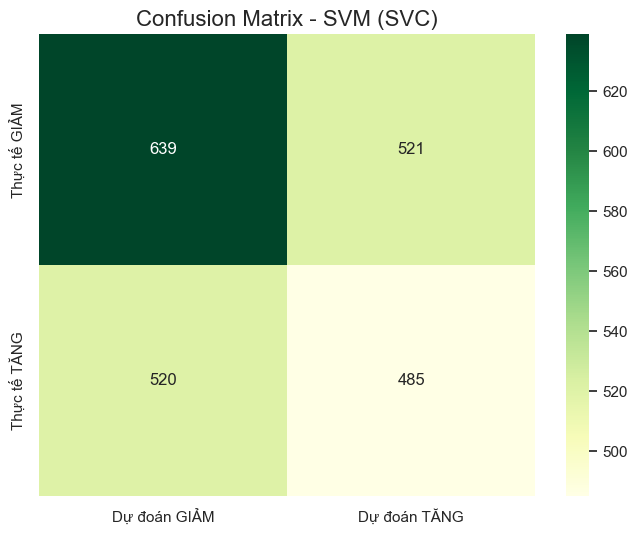

Đã lưu Confusion Matrix tại 'svm_confusion_matrix.png'

--- Đang gom file vào thư mục 'svm_model_results' ---

✅ TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: 'svm_model_results'


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- THƯ VIỆN MỚI ---
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # Bắt buộc cho SVM
# --------------------

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

def add_lag_and_interaction_features(df):
    """
    Hàm này thêm cả Đặc trưng Tương tác VÀ Đặc trưng Trễ.
    """
    # --- 1. Thêm Đặc trưng Tương tác (Interaction Features) ---
    print("--- Đang thêm Đặc trưng Tương tác ---")
    df['Price_vs_SMA'] = df['Price'] - df['SMA']
    df['Price_vs_ZLMA'] = df['Price'] - df['ZLMA']
    df['Bollinger_Width_Normalized'] = (df['Bollinger_Upper'] - df['Bollinger_Lower']) / df['SMA']

    # --- 2. Thêm Đặc trưng Trễ (Lag Features) ---
    print("\n--- Đang thêm các Đặc trưng Trễ ---")
    
    features_to_lag = {
        'ZLMA': [1, 2], 'RSI': [1, 2], 'MACD_Hist': [1, 2],
        'Change %': [1, 2], 'Vol.': [1],
        'Price_vs_SMA': [1], 'Bollinger_Width_Normalized': [1]
    }
    
    for feature, lags in features_to_lag.items():
        if feature not in df.columns:
            continue
        for lag in lags:
            col_name = f"{feature}_lag_{lag}"
            df[col_name] = df.groupby('Ticker')[feature].shift(lag)
            
    return df

try:
    # 1. ĐỌC DỮ LIỆU 
    df = pd.read_csv('stock_data_with_indicators.csv') 
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(['Ticker', 'Date'])

    # 2. CHUẨN BỊ DỮ LIỆU
    df['Next_Price'] = df.groupby('Ticker')['Price'].shift(-1)
    df['Target'] = (df['Next_Price'] > df['Price']).astype(int)
    
    df_with_features = add_lag_and_interaction_features(df)
    
    df_ml = df_with_features.dropna()

    # --- DANH SÁCH 28 FEATURES ---
    base_features = [
        'Vol.', 'Change %', 'WCP', 'VWAP', 'ZLMA', 'FWMA', 'Decay','SMA',
        'Bollinger_Upper', 'Bollinger_Lower','RSI', 'MACD', 'MACD_Signal', 'MACD_Hist'
    ]
    interaction_features = [
        'Price_vs_SMA', 'Price_vs_ZLMA', 'Bollinger_Width_Normalized'
    ]
    lag_features = [
        'ZLMA_lag_1', 'ZLMA_lag_2', 'RSI_lag_1', 'RSI_lag_2',
        'MACD_Hist_lag_1', 'MACD_Hist_lag_2', 'Change %_lag_1', 'Change %_lag_2',
        'Vol._lag_1', 'Price_vs_SMA_lag_1', 'Bollinger_Width_Normalized_lag_1'
    ]
    all_features = base_features + interaction_features + lag_features

    # 3. CHIA DỮ LIỆU (Dùng cách chia theo thời gian)
    print("\n--- DỮ LIỆU ĐÃ CHIA THEO MỐC THỜI GIAN '2024-01-01' ---")
    train_data = df_ml[df_ml['Date'] < '2024-01-01']
    test_data = df_ml[df_ml['Date'] >= '2024-01-01']
    
    if train_data.empty or test_data.empty:
        print("Lỗi: Dữ liệu huấn luyện hoặc kiểm thử bị rỗng. Hãy kiểm tra lại mốc ngày '2024-01-01'.")
    else:
        X_train = train_data[all_features]
        y_train = train_data['Target']
        
        X_test = test_data[all_features]
        y_test = test_data['Target']

        print(f"Tổng số features: {len(all_features)}")
        print(f"Mẫu huấn luyện: {len(X_train)}")
        print(f"Mẫu kiểm thử: {len(X_test)}")

        # --- BƯỚC MỚI: CHUẨN HÓA DỮ LIỆU (BẮT BUỘC) ---
        print("\n--- Đang chuẩn hóa (Scaling) dữ liệu cho SVM ---")
        scaler = StandardScaler()
        # Fit (học) trên X_train
        X_train_scaled = scaler.fit_transform(X_train)
        # Chỉ Transform (áp dụng) trên X_test
        X_test_scaled = scaler.transform(X_test)
        # ---------------------------------------------

        # 4. HUẤN LUYỆN MÔ HÌNH SVM (SVC)
        print("\n--- Bắt đầu huấn luyện mô hình SVM (SVC) ---")
        
        model = SVC(
            kernel='rbf',             # Kernel 'rbf' là lựa chọn phi tuyến mạnh mẽ
            class_weight='balanced',  # Tự động xử lý mất cân bằng
            random_state=42,
            probability=True          # Bật để có thể dự đoán xác suất (chạy chậm hơn 1 chút)
        )
        
        # Huấn luyện trên dữ liệu ĐÃ CHUẨN HÓA
        model.fit(X_train_scaled, y_train) 
        
        print("--- Mô hình SVM (SVC) đã huấn luyện thành công! ---")

        # 5. ĐÁNH GIÁ MÔ HÌNH
        # Dự đoán trên dữ liệu ĐÃ CHUẨN HÓA
        y_pred = model.predict(X_test_scaled) 
        
        print("\n--- KẾT QUẢ ĐÁNH GIÁ MÔ HÌNH SVM (SVC) ---")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy của SVM (SVC): {accuracy:.4f}")
        
        report_text = classification_report(y_test, y_pred, target_names=['GIẢM (0)', 'TĂNG (1)'], digits=4)
        print("\nBáo cáo Phân loại chi tiết:")
        print(report_text) 

        # 6. LƯU KẾT QUẢ
        output_folder = "svm_model_results"
        os.makedirs(output_folder, exist_ok=True) 
        
        report_filename = 'svm_report.txt'
        cm_filename = 'svm_confusion_matrix.png'
        
        # Lưu Báo cáo .txt
        with open(report_filename, "w", encoding="utf-8") as f:
            f.write(f"--- KẾT QUẢ MÔ HÌNH SVM (SVC) (28 Features) ---\n")
            f.write(f"Accuracy: {accuracy:.4f}\n\n")
            f.write(report_text)
        print(f"\nĐã lưu Báo cáo Phân loại tại '{report_filename}'")

        # Vẽ và lưu Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', 
                    xticklabels=['Dự đoán GIẢM', 'Dự đoán TĂNG'],
                    yticklabels=['Thực tế GIẢM', 'Thực tế TĂNG'])
        plt.title('Confusion Matrix - SVM (SVC)', fontsize=16)
        plt.savefig(cm_filename)
        plt.show() # HIỆN BIỂU ĐỒ
        plt.close()
        print(f"Đã lưu Confusion Matrix tại '{cm_filename}'")
        
        # LƯU Ý: SVM với kernel 'rbf' không có thuộc tính 'feature_importance_'
        # đơn giản như tree-based models, nên chúng ta sẽ bỏ qua biểu đồ đó.

        # Gom file
        print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
        for fname in [report_filename, cm_filename]:
            if os.path.exists(fname):
                try:
                    shutil.move(fname, os.path.join(output_folder, fname))
                except Exception as e:
                    print(f"Lỗi khi di chuyển {fname}: {e}")

        print(f"\n✅ TẤT CẢ FILE KẾT QUẢ ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_ALL_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân cụm: Liệu 5 mã cổ phiếu có thể được tự động gom thành các nhóm (cụm) có hành vi, rủi ro, và lợi nhuận tương tự nhau hay không?


# Phân cụm _ K - mean

--- Đang tổng hợp dữ liệu cho mỗi Ticker ---
Dữ liệu đã tổng hợp (mỗi mã 1 hàng):
  Ticker  mean_change  std_change      mean_vol   mean_rsi
0    FPT     0.001121    0.016276  3.924949e+06  55.250750
1    HPG     0.001197    0.020815  3.089889e+07  53.754280
2    KDH     0.000932    0.018845  1.914359e+06  53.398536
3    PNJ     0.000922    0.019583  7.890332e+05  53.394109
4    VCB     0.000613    0.018628  1.871001e+06  52.160115

--- Đang vẽ biểu đồ Elbow để tìm k ---
Đã lưu biểu đồ Elbow tại 'kmeans_elbow_plot.png'


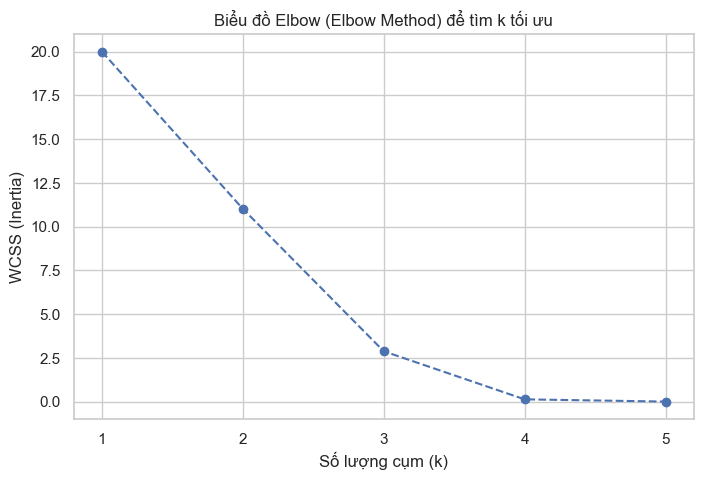


--- Đang chạy K-Means với k=3 ---
Đã lưu kết quả phân cụm tại 'stock_clusters_results.csv'
  Ticker  mean_change  std_change      mean_vol   mean_rsi Cluster
0    FPT     0.001121    0.016276  3.924949e+06  55.250750       2
1    HPG     0.001197    0.020815  3.089889e+07  53.754280       0
2    KDH     0.000932    0.018845  1.914359e+06  53.398536       1
3    PNJ     0.000922    0.019583  7.890332e+05  53.394109       1
4    VCB     0.000613    0.018628  1.871001e+06  52.160115       1

--- Đang vẽ biểu đồ Scatter Plot các cụm ---
Đã lưu biểu đồ phân cụm tại 'stock_clusters_scatterplot.png'


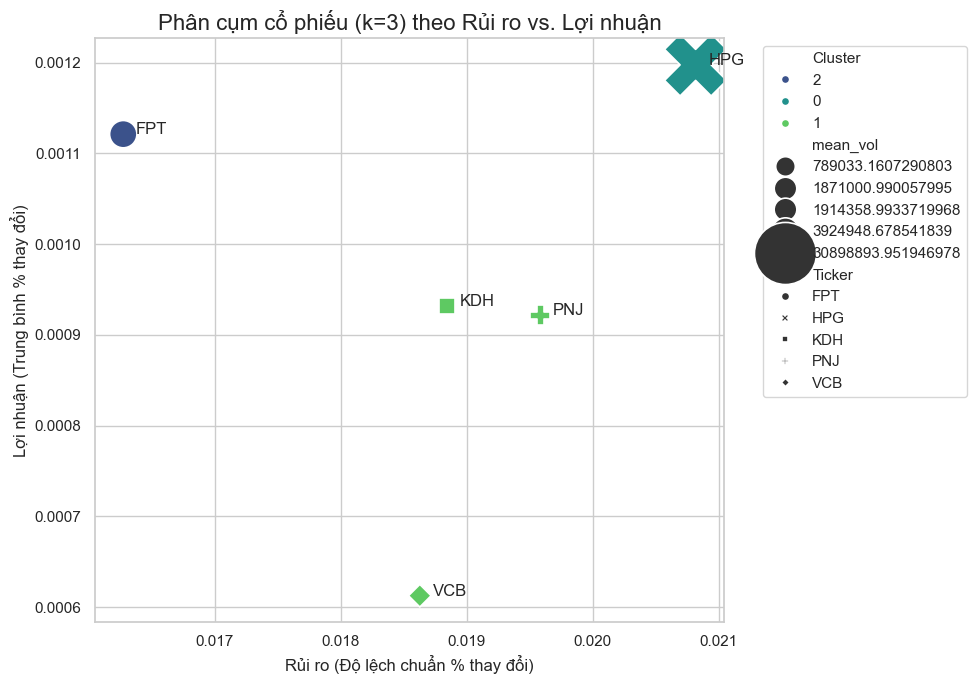


--- Đang gom file vào thư mục 'clustering_results' ---

✅ TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: 'clustering_results'


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    # 1. ĐỌC DỮ LIỆU
    df = pd.read_csv('stock_data_with_indicators.csv')
    df_clean = df.dropna() # Chỉ dùng các hàng có đủ chỉ báo

    # 2. TỔNG HỢP DỮ LIỆU (TỪ THEO NGÀY -> THEO TICKER)
    print("--- Đang tổng hợp dữ liệu cho mỗi Ticker ---")
    
    df_agg = df_clean.groupby('Ticker').agg(
        mean_change=('Change %', 'mean'),  # Lợi nhuận trung bình
        std_change=('Change %', 'std'),    # Rủi ro (độ lệch chuẩn)
        mean_vol=('Vol.', 'mean'),        # Thanh khoản trung bình
        mean_rsi=('RSI', 'mean')           # RSI trung bình (thêm 1 chỉ báo)
    ).reset_index()

    print("Dữ liệu đã tổng hợp (mỗi mã 1 hàng):")
    print(df_agg.head())

    # 3. CHUẨN HÓA DỮ LIỆU
    features_for_clustering = ['mean_change', 'std_change', 'mean_vol', 'mean_rsi']
    X = df_agg[features_for_clustering]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. TÌM k TỐI ƯU (ELBOW METHOD)
    print("\n--- Đang vẽ biểu đồ Elbow để tìm k ---")
    wcss = [] # Within-Cluster Sum of Squares
    k_range = range(1, 6) # Thử k từ 1 đến 5 (vì chỉ có 5 mã)

    for k in k_range:
        kmeans_elbow = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
        kmeans_elbow.fit(X_scaled)
        wcss.append(kmeans_elbow.inertia_) # inertia_ chính là WCSS

    # Vẽ biểu đồ Elbow
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, wcss, marker='o', linestyle='--')
    plt.title('Biểu đồ Elbow (Elbow Method) để tìm k tối ưu')
    plt.xlabel('Số lượng cụm (k)')
    plt.ylabel('WCSS (Inertia)')
    plt.xticks(k_range) # Đảm bảo hiển thị 1, 2, 3, 4, 5
    plt.grid(True)
    plt.savefig('kmeans_elbow_plot.png')
    print("Đã lưu biểu đồ Elbow tại 'kmeans_elbow_plot.png'")
    plt.show() # HIỆN BIỂU ĐỒ
    plt.close()

    # 5. ÁP DỤNG K-MEANS
    # Nhìn vào biểu đồ Elbow, giả sử ta chọn k=3 (bạn có thể đổi số này)
    optimal_k = 3
    print(f"\n--- Đang chạy K-Means với k={optimal_k} ---")
    kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Thêm kết quả phân cụm vào DataFrame tổng hợp
    df_agg['Cluster'] = clusters
    df_agg['Cluster'] = df_agg['Cluster'].astype(str) # Chuyển sang string để vẽ

    # Lưu file CSV kết quả
    output_csv = 'stock_clusters_results.csv'
    df_agg.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"Đã lưu kết quả phân cụm tại '{output_csv}'")
    print(df_agg) # In kết quả

    # 6. TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM
    print("\n--- Đang vẽ biểu đồ Scatter Plot các cụm ---")

    plt.figure(figsize=(10, 7))
    scatter_plot = sns.scatterplot(
        data=df_agg,
        x='std_change',     # Trục X = Rủi ro
        y='mean_change',    # Trục Y = Lợi nhuận
        hue='Cluster',      # Màu sắc = Cụm
        size='mean_vol',    # Kích thước = Thanh khoản
        sizes=(200, 2000),  # Tăng kích thước điểm
        palette='viridis',
        style='Ticker'      # Mỗi Ticker một hình dạng riêng
    )
    
    # Thêm nhãn cho từng điểm
    for i in range(df_agg.shape[0]):
        plt.text(
            x=df_agg['std_change'][i] + 0.0001, # Dịch nhãn 1 chút
            y=df_agg['mean_change'][i],
            s=df_agg['Ticker'][i]
        )

    plt.title(f'Phân cụm cổ phiếu (k={optimal_k}) theo Rủi ro vs. Lợi nhuận', fontsize=16)
    plt.xlabel('Rủi ro (Độ lệch chuẩn % thay đổi)', fontsize=12)
    plt.ylabel('Lợi nhuận (Trung bình % thay đổi)', fontsize=12)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1)) # Đưa chú giải ra ngoài
    plt.tight_layout()
    
    output_plot = 'stock_clusters_scatterplot.png'
    plt.savefig(output_plot)
    print(f"Đã lưu biểu đồ phân cụm tại '{output_plot}'")
    plt.show() # HIỆN BIỂU ĐỒ
    plt.close()
    
    # --- GỘP FILE VÀO THƯ MỤC ---
    output_folder = "clustering_results" 
    os.makedirs(output_folder, exist_ok=True) 

    file_patterns = [output_csv, 'kmeans_elbow_plot.png', output_plot]

    print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
    for fname in file_patterns:
        if os.path.exists(fname):
            try:
                shutil.move(fname, os.path.join(output_folder, fname))
            except Exception as e:
                print(f"Lỗi khi di chuyển {fname}: {e}")

    print(f"\n✅ TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân cụm _ DBSCAN

--- Đang tổng hợp dữ liệu cho mỗi Ticker (Giống như K-Means) ---

--- Đang chạy DBSCAN (eps=1.5, min_samples=2) ---
Kết quả phân cụm bằng DBSCAN:
  Ticker  mean_change  std_change      mean_vol   mean_rsi Cluster
0    FPT     0.001121    0.016276  3.924949e+06  55.250750      -1
1    HPG     0.001197    0.020815  3.089889e+07  53.754280      -1
2    KDH     0.000932    0.018845  1.914359e+06  53.398536       0
3    PNJ     0.000922    0.019583  7.890332e+05  53.394109       0
4    VCB     0.000613    0.018628  1.871001e+06  52.160115      -1

Đã lưu kết quả phân cụm tại 'dbscan_clusters_results.csv'

--- Đang vẽ biểu đồ Scatter Plot các cụm DBSCAN ---
Đã lưu biểu đồ phân cụm tại 'dbscan_clusters_scatterplot.png'


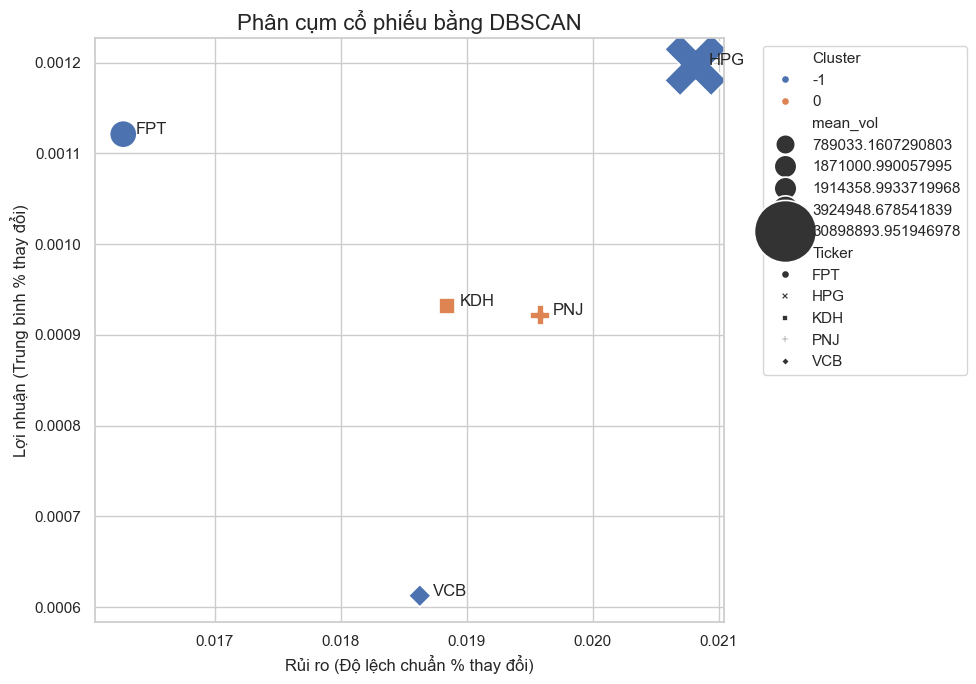


--- Đang gom file vào thư mục 'clustering_results' ---

✅ TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: 'clustering_results'


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Nhập thư viện DBSCAN
from sklearn.cluster import DBSCAN
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    # 1. ĐỌC DỮ LIỆU
    df = pd.read_csv('stock_data_with_indicators.csv')
    df_clean = df.dropna()

    # 2. TỔNG HỢP DỮ LIỆU (TỪ THEO NGÀY -> THEO TICKER)
    print("--- Đang tổng hợp dữ liệu cho mỗi Ticker (Giống như K-Means) ---")
    
    df_agg = df_clean.groupby('Ticker').agg(
        mean_change=('Change %', 'mean'),
        std_change=('Change %', 'std'),
        mean_vol=('Vol.', 'mean'),
        mean_rsi=('RSI', 'mean')
    ).reset_index()
    
    # 3. CHUẨN HÓA DỮ LIỆU (Rất quan trọng cho DBSCAN)
    features_for_clustering = ['mean_change', 'std_change', 'mean_vol', 'mean_rsi']
    X = df_agg[features_for_clustering]
    
    # Tách Ticker ra để làm nhãn
    tickers = df_agg['Ticker']
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. CHẠY PHÂN CỤM DBSCAN
    
    # eps (epsilon): Là "bán kính" của một vùng lân cận. 
    #   Vì dữ liệu đã chuẩn hóa, các giá trị thường trong khoảng (0.1, 2.0). 
    #   Chúng ta có 5 điểm trong không gian 4 chiều, chúng khá "thưa thớt".
    #   Ta sẽ thử eps=1.5
    # min_samples=2: Cần ít nhất 2 điểm để tạo thành một "vùng lõi" (cụm).
    #   Nếu đặt là 1, mọi điểm sẽ là 1 cụm.
    
    print("\n--- Đang chạy DBSCAN (eps=1.5, min_samples=2) ---")
    
    # Thử với eps=1.5, min_samples=2
    db = DBSCAN(eps=1.5, min_samples=2).fit(X_scaled)
    
    # Lấy nhãn cụm (clusters)
    # Nhãn -1 có nghĩa là NGOẠI LỆ (OUTLIER)
    clusters = db.labels_

    # 5. XEM KẾT QUẢ
    df_agg['Cluster'] = clusters
    df_agg['Cluster'] = df_agg['Cluster'].astype(str) # Chuyển sang string để vẽ

    print("Kết quả phân cụm bằng DBSCAN:")
    print(df_agg)
    
    output_csv = 'dbscan_clusters_results.csv'
    df_agg.to_csv(output_csv, index=False, encoding='utf-8')
    print(f"\nĐã lưu kết quả phân cụm tại '{output_csv}'")
    
    # 6. TRỰC QUAN HÓA KẾT QUẢ PHÂN CỤM
    print("\n--- Đang vẽ biểu đồ Scatter Plot các cụm DBSCAN ---")

    plt.figure(figsize=(10, 7))
    scatter_plot = sns.scatterplot(
        data=df_agg,
        x='std_change',     # Trục X = Rủi ro
        y='mean_change',    # Trục Y = Lợi nhuận
        hue='Cluster',      # Màu sắc = Cụm (Nhãn -1 sẽ có màu riêng)
        size='mean_vol',    # Kích thước = Thanh khoản
        sizes=(200, 2000),
        palette='deep',
        style='Ticker'      
    )
    
    # Thêm nhãn cho từng điểm
    for i in range(df_agg.shape[0]):
        plt.text(
            x=df_agg['std_change'][i] + 0.0001, 
            y=df_agg['mean_change'][i],
            s=df_agg['Ticker'][i]
        )

    plt.title('Phân cụm cổ phiếu bằng DBSCAN', fontsize=16)
    plt.xlabel('Rủi ro (Độ lệch chuẩn % thay đổi)', fontsize=12)
    plt.ylabel('Lợi nhuận (Trung bình % thay đổi)', fontsize=12)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    
    output_plot = 'dbscan_clusters_scatterplot.png'
    plt.savefig(output_plot)
    print(f"Đã lưu biểu đồ phân cụm tại '{output_plot}'")
    plt.show() # HIỆN BIỂU ĐỒ
    plt.close()
    
    # --- GỘP FILE VÀO THƯ MỤC ---
    output_folder = "clustering_results" 
    os.makedirs(output_folder, exist_ok=True) 

    file_patterns = [output_csv, output_plot]

    print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
    for fname in file_patterns:
        if os.path.exists(fname):
            try:
                shutil.move(fname, os.path.join(output_folder, fname))
            except Exception as e:
                print(f"Lỗi khi di chuyển {fname}: {e}")

    print(f"\n✅ TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_ALL_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: sklearn) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")

# Phân cụm _ Hierarchical Clustering

--- Đang tổng hợp dữ liệu cho mỗi Ticker (Giống như K-Means) ---

--- Đang tạo Linkage Matrix (Ma trận liên kết) ---
--- Đang vẽ biểu đồ Dendrogram ---
Đã lưu biểu đồ Dendrogram tại 'hierarchical_dendrogram.png'


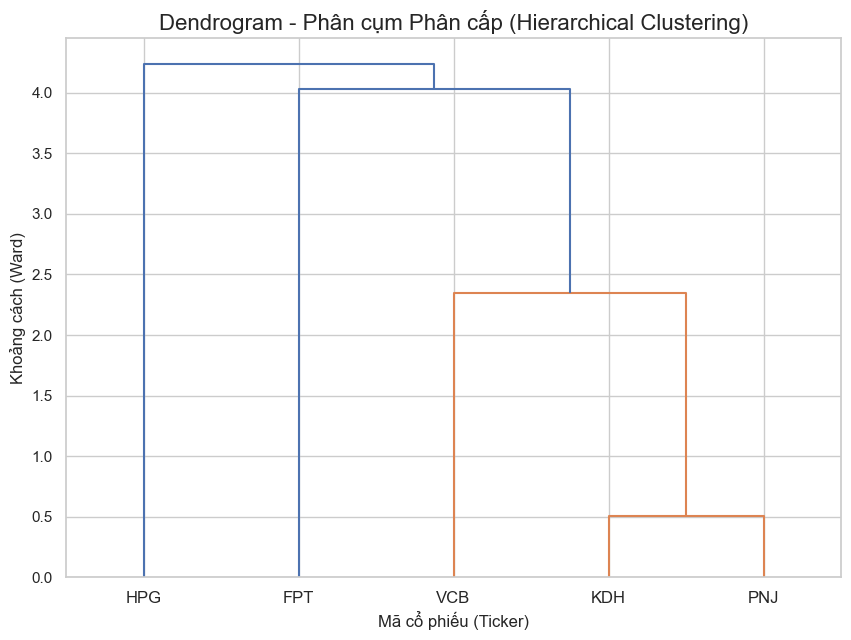


--- Đang gom file vào thư mục 'clustering_results' ---

 TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: 'clustering_results'


In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Nhập thư viện Phân cụm Phân cấp
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
import os
import shutil

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

try:
    # 1. ĐỌC DỮ LIỆU
    df = pd.read_csv('stock_data_with_indicators.csv')
    df_clean = df.dropna()

    # 2. TỔNG HỢP DỮ LIỆU (TỪ THEO NGÀY -> THEO TICKER)
    print("--- Đang tổng hợp dữ liệu cho mỗi Ticker (Giống như K-Means) ---")
    
    df_agg = df_clean.groupby('Ticker').agg(
        mean_change=('Change %', 'mean'),
        std_change=('Change %', 'std'),
        mean_vol=('Vol.', 'mean'),
        mean_rsi=('RSI', 'mean')
    ).reset_index()

    # 3. CHUẨN HÓA DỮ LIỆU (Giống như K-Means)
    features_for_clustering = ['mean_change', 'std_change', 'mean_vol', 'mean_rsi']
    
    # Chúng ta phải set_index('Ticker') để dùng Ticker làm nhãn cho biểu đồ
    df_agg_indexed = df_agg.set_index('Ticker')
    X = df_agg_indexed[features_for_clustering]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4. CHẠY PHÂN CỤM PHÂN CẤP (Hierarchical Clustering)
    
    # 'method='ward'' là một phương pháp phổ biến để tính toán khoảng cách giữa các cụm
    # Nó cố gắng giảm thiểu phương sai (variance) trong mỗi cụm
    print("\n--- Đang tạo Linkage Matrix (Ma trận liên kết) ---")
    Z = linkage(X_scaled, method='ward')

    # 5. VẼ BIỂU ĐỒ DENDROGRAM (Cây phân cấp)
    print("--- Đang vẽ biểu đồ Dendrogram ---")
    
    plt.figure(figsize=(10, 7))
    dendrogram(
        Z,
        labels=df_agg_indexed.index.to_list(), # Lấy tên Ticker làm nhãn
        leaf_rotation=0,  # Xoay nhãn
        leaf_font_size=12 # Tăng cỡ chữ
    )

    plt.title('Dendrogram - Phân cụm Phân cấp (Hierarchical Clustering)', fontsize=16)
    plt.ylabel('Khoảng cách (Ward)', fontsize=12)
    plt.xlabel('Mã cổ phiếu (Ticker)', fontsize=12)
    
    output_plot = 'hierarchical_dendrogram.png'
    plt.savefig(output_plot)
    print(f"Đã lưu biểu đồ Dendrogram tại '{output_plot}'")
    plt.show() # HIỆN BIỂU ĐỒ
    plt.close()
    
    # --- GỘP FILE VÀO THƯ MỤC ---
    output_folder = "clustering_results" 
    os.makedirs(output_folder, exist_ok=True) 

    file_patterns = [output_plot]

    print(f"\n--- Đang gom file vào thư mục '{output_folder}' ---")
    for fname in file_patterns:
        if os.path.exists(fname):
            try:
                shutil.move(fname, os.path.join(output_folder, fname))
            except Exception as e:
                print(f"Lỗi khi di chuyển {fname}: {e}")

    print(f"\n TẤT CẢ FILE PHÂN CỤM ĐÃ GỘP VÀO THƯ MỤC: '{output_folder}'")

except FileNotFoundError:
    print(f"\nLỗi: Không tìm thấy tệp 'stock_data_with_indicators.csv'.")
except ImportError:
    print("\nLỗi: Thư viện (ví dụ: scipy) chưa được cài đặt.")
except Exception as e:
    print(f"\nĐã xảy ra một lỗi không mong muốn: {e}")